# Setup

In [2]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import torch
from transformers import AutoConfig, AutoModelForCausalLM, PreTrainedModel
from safetensors.torch import load_model, save_model, safe_open
from weak_to_strong.model import TransformerWithHead
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Representation Extraction

In [3]:
def get_activation(name, activations):
    """ Helper function to capture the activation at each layer. """
    def hook(model, input, output):
        # We expect 'output' to be a tuple where the first element is the last hidden state
        activations[name] = output[0].detach()
    return hook

def extract_hidden_states(model, datapoint):
    """ Extract hidden states for all layers of a given model for a specific datapoint. """
    activations = {}
    hooks = []

    # Registering hooks for each layer of the transformer
    for name, module in model.transformer.named_modules():
        if isinstance(module, torch.nn.modules.Module):  # You may want to filter only certain types of layers
            hook = module.register_forward_hook(get_activation(name, activations))
            hooks.append(hook)

    # Run the datapoint through the model
    model.eval()
    with torch.no_grad():
        _ = model(datapoint)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return activations

def compare_models(model_name, finetuned_model_path, datapoint): 
    """ Extract and compare hidden states from two models for a given datapoint. """
        # Load both models
    pre_model = TransformerWithHead.from_pretrained(model_name)
    post_model = TransformerWithHead.from_pretrained(model_name)
    
    load_model(post_model, finetuned_model_path)
    
    # datapoint = datapoint.to(model1.device)  # Ensure datapoint is on the same device as model
    activations_model1 = extract_hidden_states(pre_model, datapoint)
    activations_model2 = extract_hidden_states(post_model, datapoint)
    
    return activations_model1, activations_model2

def plot_activation_changes(activations_pre, activations_post, layer_name, method='PCA', components=2):
    """
    Visualize changes in activations using PCA or t-SNE.

    Parameters:
    activations_pre (dict): Activations from the model before finetuning.
    activations_post (dict): Activations from the model after finetuning.
    layer_name (str): The layer whose activations are to be visualized.
    method (str): 'PCA' or 't-SNE', the method to use for dimensionality reduction.
    components (int): Number of components for the dimensionality reduction.
    """
    # Extract activations for a specific layer
    data_pre = activations_pre[layer_name].cpu().numpy()
    data_post = activations_post[layer_name].cpu().numpy()
    
    # Concatenate data from both states for unified transformation in PCA/t-SNE
    data_combined = np.concatenate([data_pre, data_post], axis=0)
    
    if method == 'PCA':
        reducer = PCA(n_components=components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=components, learning_rate='auto', init='random')
    else:
        raise ValueError("Unsupported dimensionality reduction method")

    # Fit and transform the data
    reduced_data = reducer.fit_transform(data_combined)
    
    # Split the transformed data
    reduced_data_pre = reduced_data[:data_pre.shape[0]]
    reduced_data_post = reduced_data[data_pre.shape[0]:]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data_pre[:, 0], reduced_data_pre[:, 1], c='blue', alpha=0.5, label='Pre-Finetuning')
    plt.scatter(reduced_data_post[:, 0], reduced_data_post[:, 1], c='red', alpha=0.5, label='Post-Finetuning')
    plt.title(f'Layer: {layer_name} - {method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.legend()
    plt.show()

### Usage Example

In [28]:
model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

finetuned_model_path = "/home/slhleosun/weak-to-strong-main/results/default/bs=32-dn=amaz_pola-e=2-ee=1000000-lp=0-l=xent-l=5e-05-ls=cosi_anne-mc=1024-ms=gpt2-nd=20000-ntd=10000-o=adam-s=0-twd=0/model.safetensors"

In [29]:
datapoint = torch.randint(50257, (1, 10))  # Sample input ids, assuming GPT-2's vocabulary size

activations1, activations2 = compare_models(model_name, finetuned_model_path, datapoint)

In [30]:
activations1, activations2

({'wte': tensor([[ 0.0903, -0.0299,  0.0485,  ...,  0.1106,  0.1219,  0.0183],
          [ 0.2138, -0.1895,  0.0829,  ..., -0.2281,  0.1964, -0.2193],
          [-0.1172,  0.0647,  0.2248,  ...,  0.1247,  0.1529, -0.0621],
          ...,
          [-0.0150, -0.1909,  0.0905,  ...,  0.2641,  0.0922, -0.1219],
          [ 0.0177,  0.0124,  0.0919,  ...,  0.1523,  0.0552,  0.0196],
          [-0.1263, -0.0279,  0.0618,  ..., -0.0761,  0.0568,  0.0148]]),
  'wpe': tensor([[-1.8821e-02, -1.9742e-01,  4.0267e-03,  ..., -4.3044e-02,
            2.8267e-02,  5.4490e-02],
          [ 2.3959e-02, -5.3792e-02, -9.4879e-02,  ...,  3.4170e-02,
            1.0172e-02, -1.5573e-04],
          [ 4.2161e-03, -8.4764e-02,  5.4515e-02,  ...,  1.9745e-02,
            1.9325e-02, -2.1424e-02],
          ...,
          [ 2.5308e-03, -3.1787e-03,  1.1741e-01,  ...,  2.0096e-03,
            4.4180e-03, -6.8326e-03],
          [-1.2381e-03, -1.7734e-03,  1.1104e-01,  ..., -2.3007e-03,
            4.1536e-03, -

### Guide for Interpreting 
- The relative position of blue and red dots indicates how similar or different the activations are before and after finetuning. If they overlap significantly, the representations are relatively stable through finetuning. If they are separate, it suggests that finetuning has significantly shifted the activations.
- The shift from blue to red dots indicates the direction of change in the hidden states due to finetuning. For instance, if the red dots are predominantly to the right of the blue dots, this indicates that the activations have shifted along the direction represented by PCA Component 1.
- Any consistent pattern of shift (e.g., most red dots are in a specific quadrant relative to the blue dots) may suggest how finetuning has affected the internal representations of the neural network. Perhaps the finetuning has made the network more sensitive to certain features, or has made it focus on different aspects of the input data.

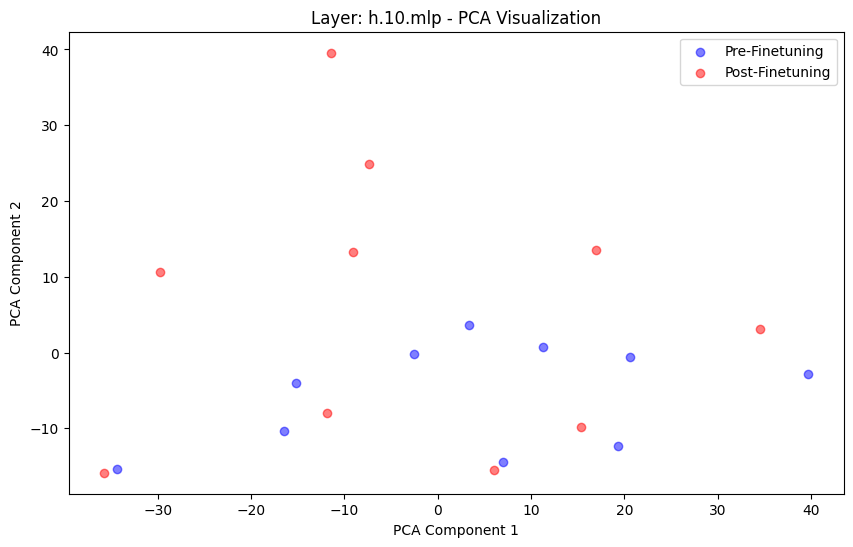

In [35]:
plot_activation_changes(activations1, activations2, 'h.10.mlp', method='PCA')

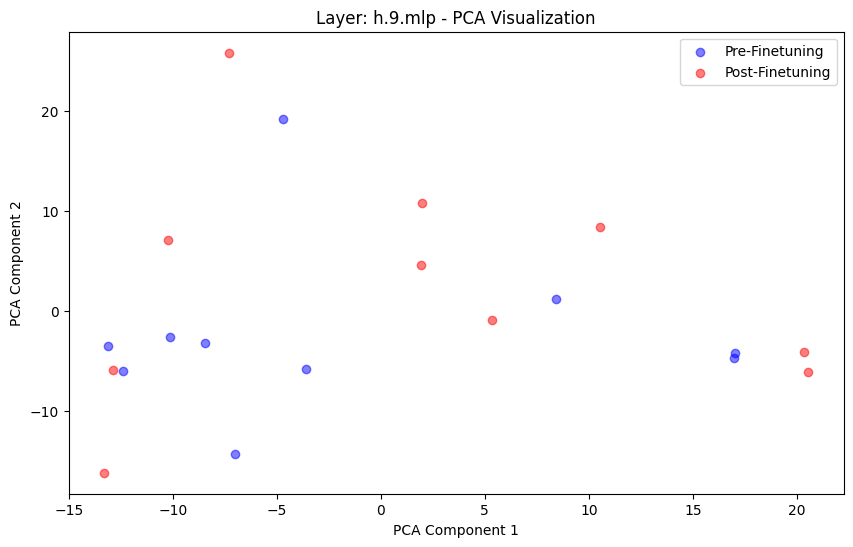

In [36]:
plot_activation_changes(activations1, activations2, 'h.9.mlp', method='PCA')

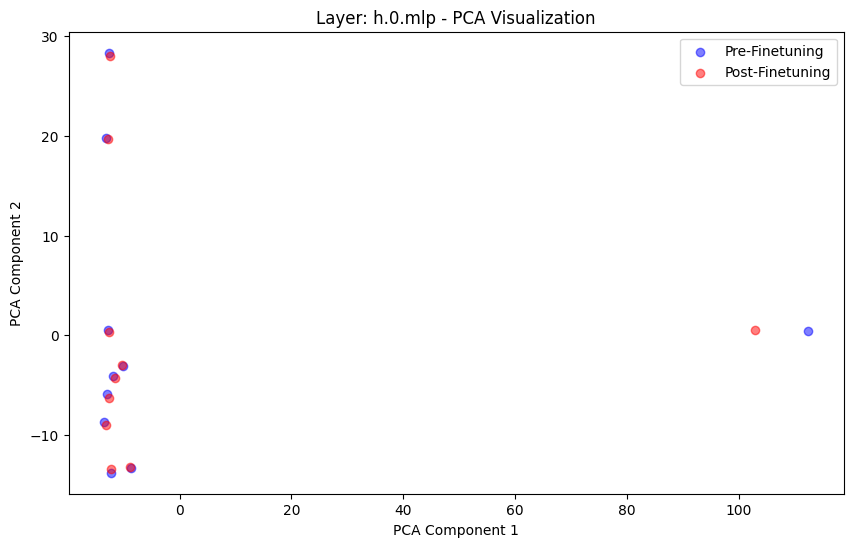

In [37]:
plot_activation_changes(activations1, activations2, 'h.0.mlp', method='PCA')

# Legacy: Weight Changes

In [10]:
def extract_model_weights(model):
    weights = []
    # Iterate through each block in the GPT-2 transformer
    for block in model.transformer.h:
        # Each block has two main components: the attention mechanism and the MLP
        # Extract weights from attention mechanism's query, key, value matrices
        attn = block.attn
        weights.append(attn.query.weight.data)
        weights.append(attn.key.weight.data)
        weights.append(attn.value.weight.data)
        weights.append(attn.out.weight.data)
        
        # Extract weights from MLP
        mlp = block.mlp
        weights.append(mlp.c_fc.weight.data)
        weights.append(mlp.c_proj.weight.data)
    return weights

weights_pre = pre_model.score.weight.detach().numpy()
weights_post = post_model.score.weight.detach().numpy()


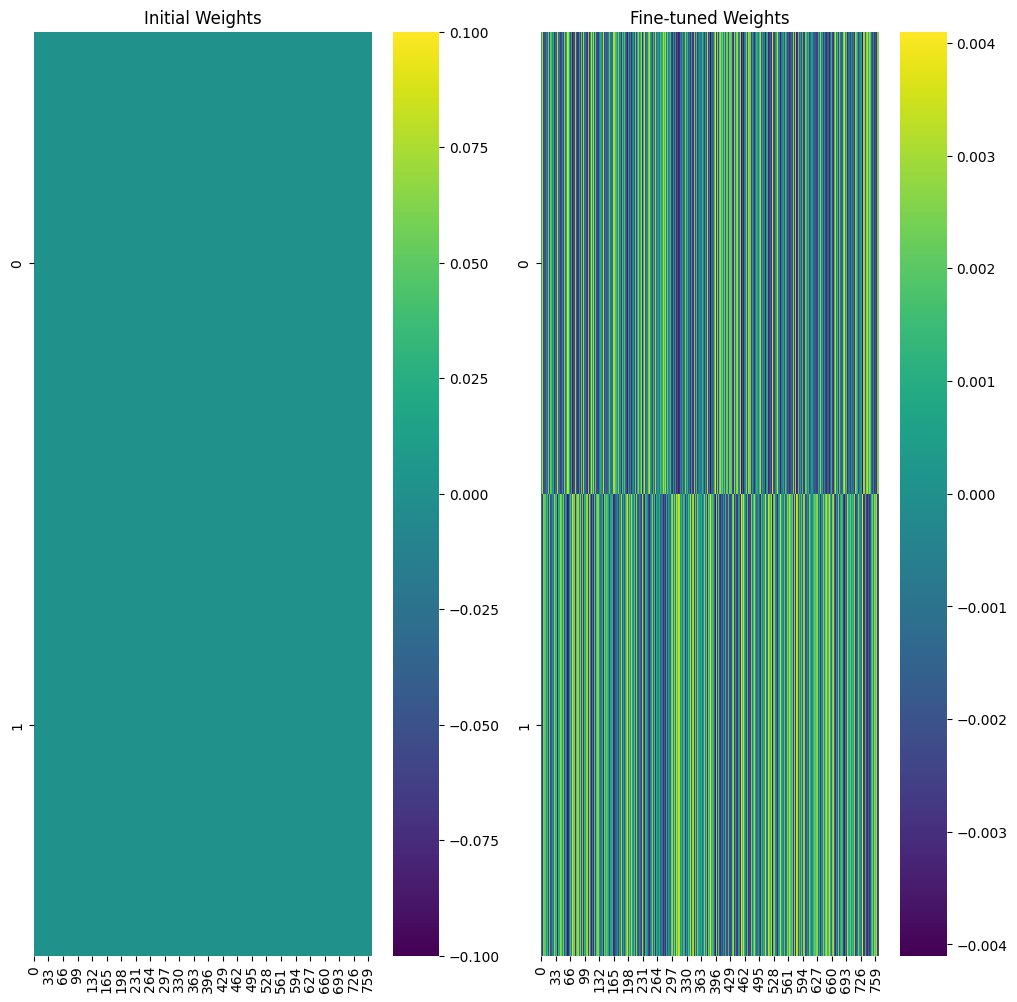

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

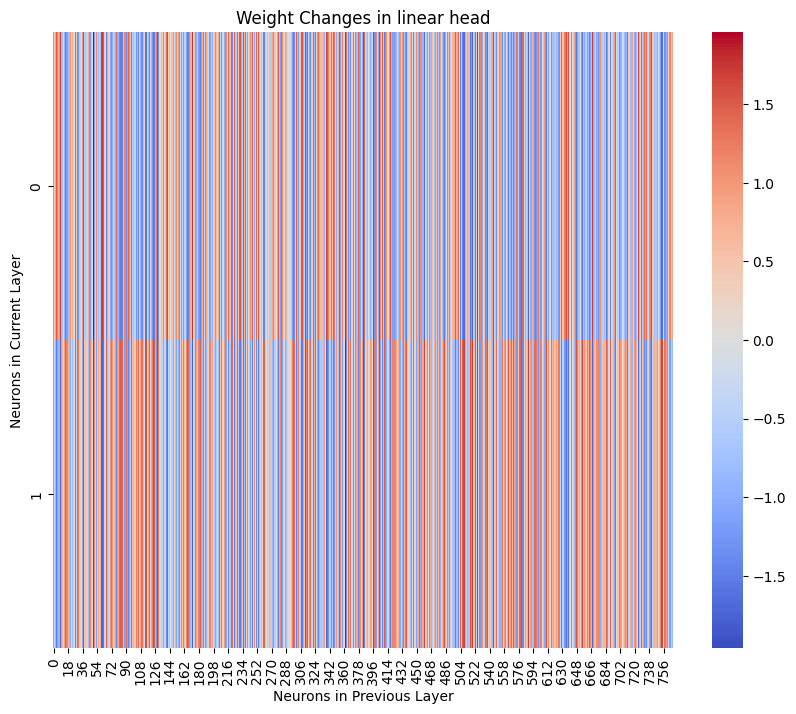

In [30]:
def visualize_weights(initial_weights, finetuned_weights):
    fig, axs = plt.subplots(1, 2, figsize=(12, 12))
    sns.heatmap(initial_weights, ax=axs[0], cmap='viridis')
    axs[0].set_title('Initial Weights')
    sns.heatmap(finetuned_weights, ax=axs[1], cmap='viridis')
    axs[1].set_title('Fine-tuned Weights')
    plt.show()
    
visualize_weights(weights_pre, weights_post)
visualize_weight_changes(weights_pre, weights_post, "linear head")

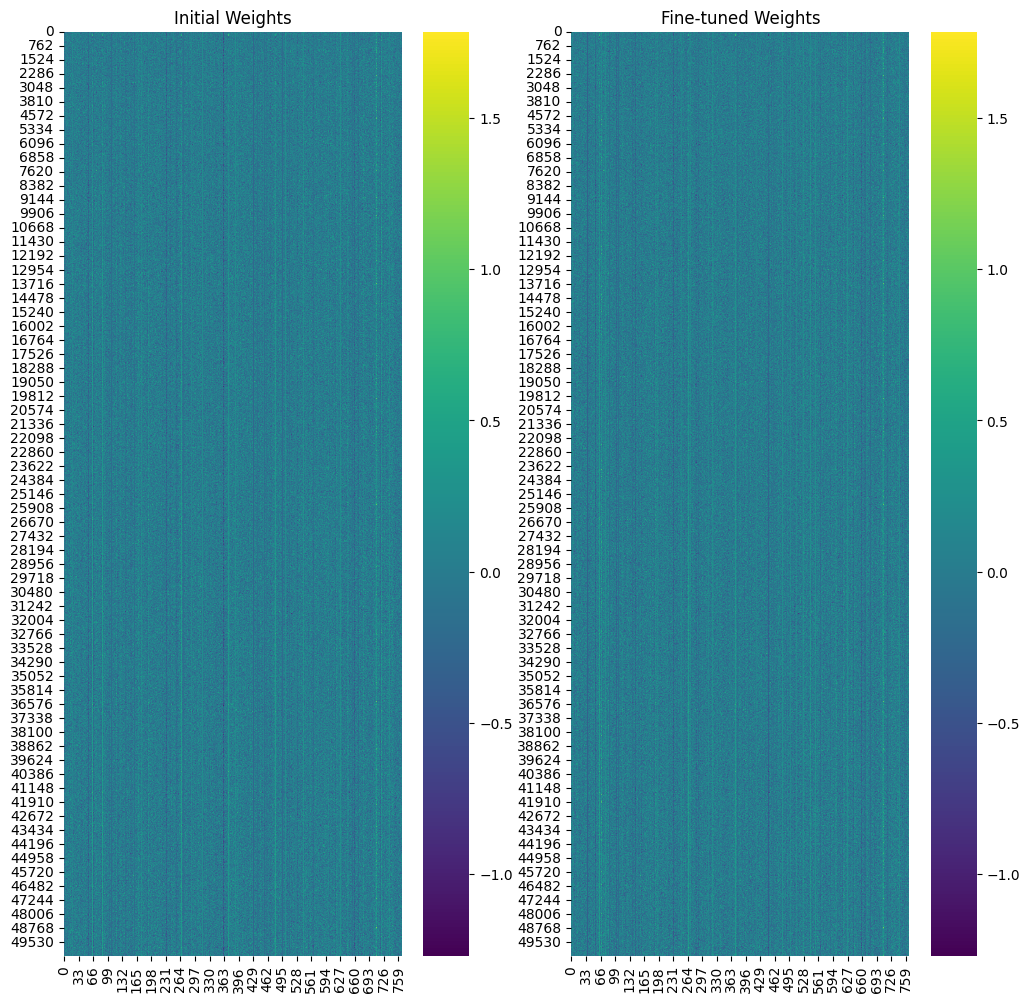

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [ ]:
original_weights = pre_model.transformer.wte.weight.detach().numpy()  # Example: word embedding layer
finetuned_weights = post_model.transformer.wte.weight.detach().numpy()

visualize_weights(original_weights, finetuned_weights)
visualize_weight_changes(original_weights, finetuned_weights, "word embedding")

In [ ]:
original_weights = pre_model.transformer.wte.weight.detach().numpy()  # Example: word embedding layer
finetuned_weights = post_model.transformer.wte.weight.detach().numpy()

visualize_weights(original_weights, finetuned_weights)

In [ ]:
original_query_weights = original_model.transformer.h[0].attn.c_attn.weight.detach().numpy()
original_key_weightsb = original_model.transformer.h[0].attn.c_attn.weight.detach().numpy()
original_value_weights = original_model.transformer.h[0].attn.c_attn.weight.detach().numpy()


In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_weight_changes(initial_weights, finetuned_weights, layer_name):
    # Calculate the absolute differences between the weights
    weight_differences = finetuned_weights - initial_weights
    
    # Normalize the differences to have a better visual comparison
    # This is optional and can be commented out if raw differences are preferred
    weight_differences = weight_differences / np.std(weight_differences)
    
    # Visualize the differences using a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(weight_differences, cmap='coolwarm', center=0)
    plt.title(f'Weight Changes in {layer_name}')
    plt.xlabel('Neurons in Previous Layer')
    plt.ylabel('Neurons in Current Layer')
    plt.colorbar(label='Magnitude of Weight Change')
    plt.show()


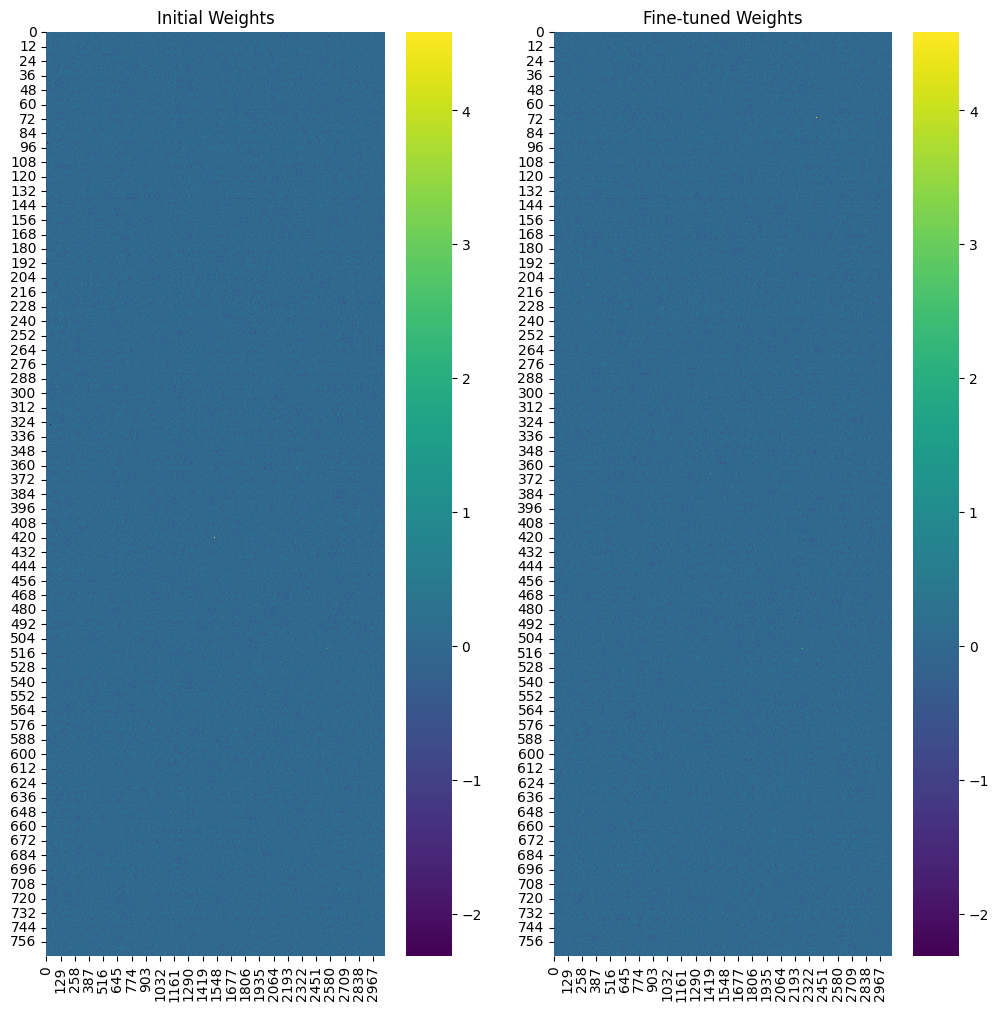

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

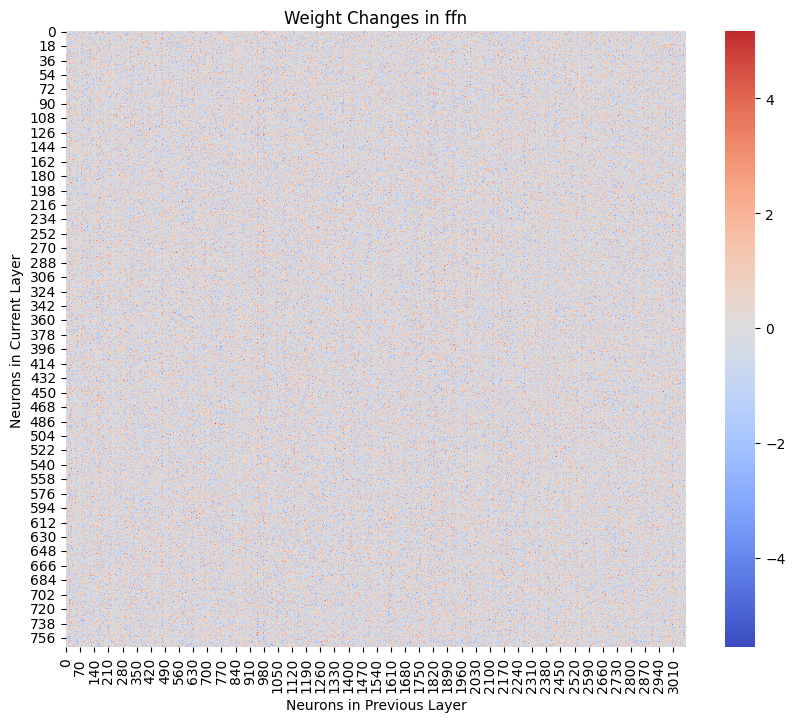

In [29]:
original_ffn_weights = pre_model.transformer.h[0].mlp.c_fc.weight.detach().numpy()
finetuned_ffn_weights = post_model.transformer.h[0].mlp.c_fc.weight.detach().numpy()

visualize_weights(original_ffn_weights, finetuned_ffn_weights)
visualize_weight_changes(original_ffn_weights, finetuned_ffn_weights, "ffn")

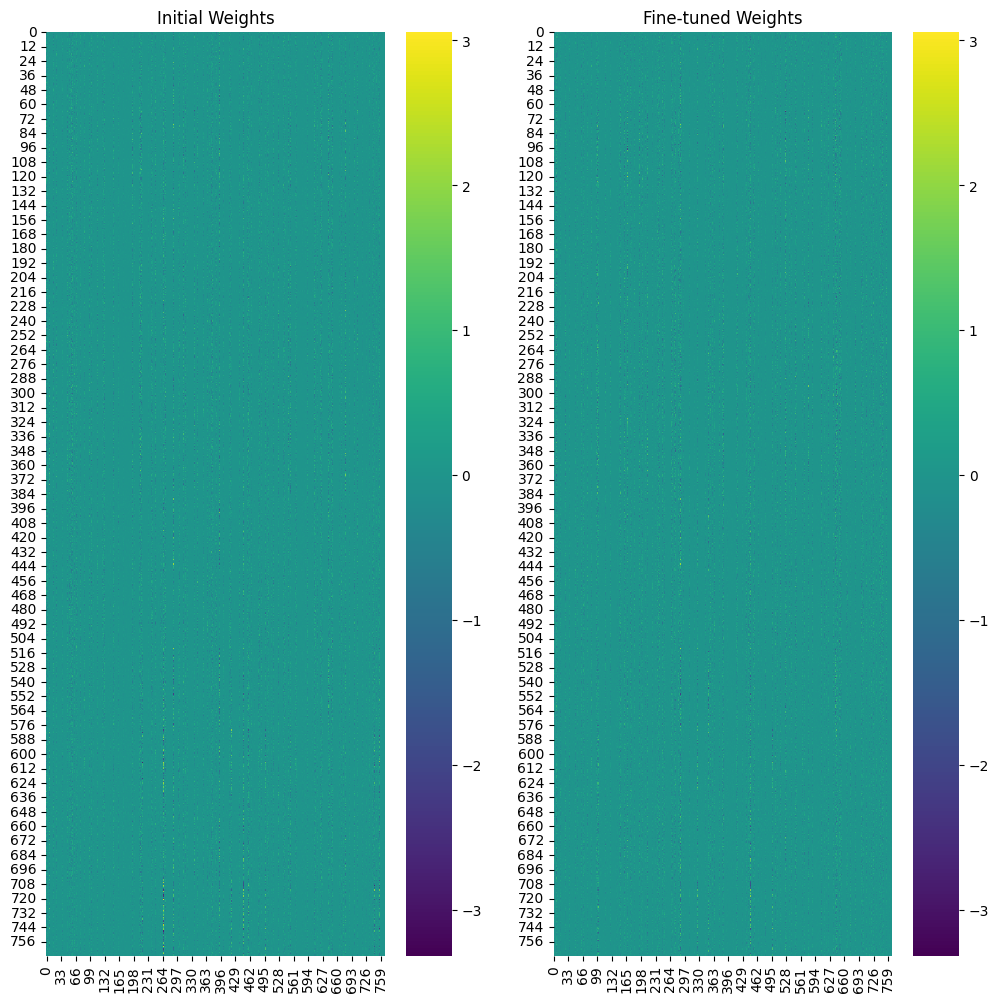

In [27]:
original_weights = pre_model.transformer.h[0].attn.c_proj.weight.detach().numpy()
finetuned_weights = post_model.transformer.h[0].attn.c_proj.weight.detach().numpy()

visualize_weights(original_weights, finetuned_weights)

In [13]:



input_text = ""
layer_num = -2  # Use the second last layer



# plot_hidden_state_shifts(model_name, finetuned_model_path, layer_num, tokenizer, input_text)

In [12]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.8 MB/s eta 0:00:00a 0:00:01


In [20]:
tensors

{'lm.transformer.h.0.attn.c_attn.bias': tensor([ 0.4812, -0.5249, -0.4288,  ...,  0.0136, -0.0503,  0.0027],
        device='cuda:0'),
 'lm.transformer.h.0.attn.c_attn.weight': tensor([[-0.4725, -0.2611, -0.0985,  ...,  0.0520, -0.0592,  0.0260],
         [ 0.0867,  0.1466,  0.2390,  ..., -0.0545, -0.0112, -0.0151],
         [ 0.0043,  0.0710,  0.3678,  ...,  0.1136,  0.0359, -0.0325],
         ...,
         [-0.2587, -0.0165,  0.1987,  ...,  0.0085, -0.0513,  0.0317],
         [ 0.1506,  0.2172,  0.1037,  ...,  0.0290, -0.0426, -0.0465],
         [-0.4106, -0.1919, -0.2388,  ..., -0.0036,  0.0083,  0.0210]],
        device='cuda:0'),
 'lm.transformer.h.0.attn.c_proj.bias': tensor([ 1.5024e-01, -1.5370e-01, -1.4688e-01, -9.9364e-02,  3.4569e-02,
         -3.4644e-02, -7.0443e-02, -9.3438e-02,  8.1596e-02,  3.1345e-02,
         -1.9869e-01, -3.6759e-02,  3.0135e-03,  5.0143e-02, -5.2860e-02,
          3.7432e-02, -1.9000e-01, -8.1408e-02,  4.9246e-02,  1.4260e-01,
         -1.1226e-01, 

In [27]:
post_model = TransformerWithHead.from_pretrained(model_name)